In [87]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from numpy import zeros_like
from IPython.display import display
def display_matrix(m):
    display(sympy.Matrix(m))
import sympy
import pandas as pd
import scipy.stats as ss

sympy.init_printing()

from Pricer import Pricer
from Processes import Processes

from scipy.stats.qmc import Sobol
from scipy.stats import norm

In [88]:
basis = 'leguerre'

# parameters

mu = 0.06
r = 0.06
sigma = 0.04
T = 1
I = 250
paths = 1000
S0 = 40
S0_list = range(37, 43, 1)
m = 0
K = 40
deg = 3

GBM_sigma = sigma
GBM_mu = r

LN_lam = 1
LN_sigma = 0.02
LN_mu = r
LN_v = 0.02

JR_lam = 0.01
JR_sigma = 0.03
JR_mu = r + JR_lam

LNparams = (LN_lam, LN_sigma, LN_mu, LN_v, m)
JRparams = (JR_lam, JR_sigma, JR_mu)
GBMparams = (GBM_mu, GBM_sigma)

# instance
processes = Processes(S0, r, T, K, paths, I, LNparams, JRparams, GBMparams)
pricer = Pricer(S0, r, sigma, T, K, paths, I, LNparams, JRparams, GBMparams)

Processes class created with S0 = 40, paths = 1000, I = 250, T = 1


In [89]:
GBM_paths = processes.gbm_paths()
LN_paths = processes.merton_jump_paths()
JR_paths = processes.merton_jump_to_ruin_paths()

In [90]:
#european price
GBM_euro_payoff = pricer.closed_formula_GBM(S0, K, T, r, sigma)
LN_euro_payoff = pricer.closed_formula_LN(S0, K, T, r, 10000)
JR_euro_payoff = pricer.closed_formula_JR(S0, K, T, r, sigma)

In [91]:
V0_GBM, V0_array_GBM, SE_GBM, exercise_matrix_GBM, V_GBM = pricer.LSM(GBM_paths, basis, deg)
V0_LN, V0_array_LN, SE_LN, exercise_matrix_LN, V_LN = pricer.LSM(LN_paths, basis, deg)
V0_JR, V0_array_JR, SE_JR, exercise_matrix_JR, V_JR = pricer.LSM(JR_paths, basis, deg)

In [92]:
print('GBM european price: ', GBM_euro_payoff, 'GBM LSM price: ', V0_GBM)
print('LN european price: ', LN_euro_payoff, 'LN LSM price: ', V0_LN)
print('JR european price: ', JR_euro_payoff, 'JR LSM price: ', V0_JR)

GBM european price:  0.045498454729779425 GBM LSM price:  0.18857544239305807
LN european price:  0.07136569952451922 LN LSM price:  0.10122079453148475
JR european price:  0.045498454729779425 JR LSM price:  0.36056464682530115


In [93]:
crude_monte_carlo_european_GBM = pricer.crude_monte_carlo_european(GBM_paths)
crude_monte_carlo_european_LN = pricer.crude_monte_carlo_european(LN_paths)
crude_monte_carlo_european_JR = pricer.crude_monte_carlo_european(JR_paths)

In [94]:
cov_GBM = np.cov(crude_monte_carlo_european_GBM, V0_array_GBM)
cov_LN = np.cov(crude_monte_carlo_european_LN, V0_array_LN)
cov_JR = np.cov(crude_monte_carlo_european_JR, V0_array_JR)

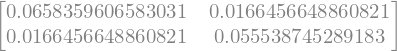

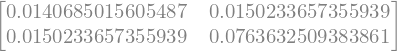

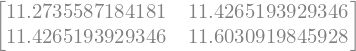

In [95]:
display_matrix(cov_GBM)
display_matrix(cov_LN)
display_matrix(cov_JR)

In [96]:
print(f'GBM cov: ' + str(cov_GBM[0, 1]))
print(f'LN cov: ' + str(cov_LN[0, 1]))
print(f'JR cov: ' + str(cov_JR[0, 1]))


GBM cov: 0.016645664886082125
LN cov: 0.015023365735593885
JR cov: 11.426519392934644


In [97]:
alpha_GBM = -cov_GBM[0, 1] / cov_GBM[0, 0]
alpha_LN = -cov_LN[0, 1] / cov_LN[0, 0]
alpha_JR = -cov_JR[0, 1] / cov_JR[0, 0]

In [98]:
print('alpha_GBM: ', alpha_GBM)
print('alpha_LN: ', alpha_LN)
print('alpha_JR: ', alpha_JR)

alpha_GBM:  -0.25283545223066184
alpha_LN:  -1.0678724859883333
alpha_JR:  -1.013568091348711


In [99]:
adjusted_payoff_GBM = V0_GBM + alpha_GBM * (crude_monte_carlo_european_GBM - np.mean(GBM_euro_payoff))
adjusted_payoff_LN = V0_LN + alpha_LN * (crude_monte_carlo_european_LN - np.mean(LN_euro_payoff))
adjusted_payoff_JR = V0_JR + alpha_JR * (crude_monte_carlo_european_JR - np.mean(JR_euro_payoff))

In [100]:
corrected_GBM_price = np.mean(adjusted_payoff_GBM)
corrected_LN_price = np.mean(adjusted_payoff_LN)
corrected_JR_price = np.mean(adjusted_payoff_JR)

In [101]:
correlated_GBM_SE = np.std(adjusted_payoff_GBM) / np.sqrt(paths)
correlated_LN_SE = np.std(adjusted_payoff_LN) / np.sqrt(paths)
correlated_JR_SE = np.std(adjusted_payoff_JR) / np.sqrt(paths)

GBM

In [102]:
print('price and se before correction: ', V0_GBM, SE_GBM)
print('price and se after correction: ', corrected_GBM_price, correlated_GBM_SE)

price and se before correction:  0.18857544239305807 0.007448705024626344
price and se after correction:  0.18568339801947625 0.0020504647265787


LN

In [103]:
print('price and se before correction: ', V0_LN, SE_LN)
print('price and se after correction: ', corrected_LN_price, correlated_LN_SE)

price and se before correction:  0.10122079453148475 0.008734236525732963
price and se after correction:  0.16186358800366593 0.0040033730624392935


JR

In [104]:
print('price and se before correction: ', V0_JR, SE_JR)
print('price and se after correction: ', corrected_JR_price, correlated_JR_SE)

price and se before correction:  0.36056464682530115 0.10766377706827952
price and se after correction:  0.09544638716583463 0.10756381313622135


In [105]:
price_diff_GBM = abs(corrected_GBM_price - GBM_euro_payoff)
price_diff_LN = abs(corrected_LN_price - LN_euro_payoff)
price_diff_JR = abs(corrected_JR_price - JR_euro_payoff)

In [106]:
print('price difference: ', price_diff_GBM)
print('price difference: ', price_diff_LN)
print('price difference: ', price_diff_JR)

price difference:  0.14018494328969683
price difference:  0.09049788847914671
price difference:  0.049947932436055206


In [107]:
se_diff_GBM = abs(correlated_GBM_SE - SE_GBM)
se_diff_LN = abs(correlated_LN_SE - SE_LN)
se_diff_JR = abs(correlated_JR_SE - SE_JR)

In [108]:
print('se difference: ', se_diff_GBM)
print('se difference: ', se_diff_LN)
print('se difference: ', se_diff_JR)

se difference:  0.005398240298047644
se difference:  0.00473086346329367
se difference:  9.996393205817522e-05


In [110]:
def sampling_at_exercise(paths):
    if paths == 'GBM_paths':
        european_put_prices = np.zeros_like(exercise_matrix_GBM, dtype=float)

        for path in range(exercise_matrix_GBM.shape[0]):
            for time in range(exercise_matrix_GBM.shape[1]):
                if exercise_matrix_GBM[path, time]:
                    S_at_exercise = GBM_paths[path, time]
                    t = time * (T / I)  # Current time in years
                    undiscounted_price = pricer.closed_formula_GBM(S_at_exercise, K, T-t, r, sigma)
                    discount_factor = np.exp(-r * t)  # Discount factor back to time 0
                    european_put_prices[path, time] = undiscounted_price * discount_factor

        first_exercise_prices = np.zeros(european_put_prices.shape[0])

        for path in range(european_put_prices.shape[0]):
            # Find the first non-zero price for this path
            first_exercise_price = next((price for price in european_put_prices[path, :] if price > 0), 0)
            first_exercise_prices[path] = first_exercise_price

        crude_monte_carlo_european_GBM = pricer.crude_monte_carlo_european(GBM_paths)

        cov = np.cov(crude_monte_carlo_european_GBM, V0_array_GBM)

        alpha = -cov[0, 1] / cov[0, 0]

        adjusted_payoff = V0_GBM + alpha * (crude_monte_carlo_european_GBM - np.mean(first_exercise_prices))

    elif paths == 'LN_paths':

        european_put_prices = np.zeros_like(exercise_matrix_LN, dtype=float)

        for path in range(exercise_matrix_LN.shape[0]):
            for time in range(exercise_matrix_LN.shape[1]):
                if exercise_matrix_LN[path, time]:
                    S_at_exercise = LN_paths[path, time]
                    t = time * (T / I)  # Current time in years
                    undiscounted_price = pricer.closed_formula_LN(S_at_exercise, K, T-t, r, 1000000)
                    discount_factor = np.exp(-r * t)  # Discount factor back to time 0
                    european_put_prices[path, time] = undiscounted_price * discount_factor

        first_exercise_prices = np.zeros(european_put_prices.shape[0])

        for path in range(european_put_prices.shape[0]):
            # Find the first non-zero price for this path
            first_exercise_price = next((price for price in european_put_prices[path, :] if price > 0), 0)
            first_exercise_prices[path] = first_exercise_price

        crude_monte_carlo_european = pricer.crude_monte_carlo_european(LN_paths)

        cov = np.cov(crude_monte_carlo_european, V0_array_LN)

        alpha = -cov[0, 1] / cov[0, 0]

        adjusted_payoff = V0_LN + alpha * (crude_monte_carlo_european - np.mean(first_exercise_prices))

    else:
        european_put_prices = np.zeros_like(exercise_matrix_JR, dtype=float)

        for path in range(exercise_matrix_JR.shape[0]):
            for time in range(exercise_matrix_JR.shape[1]):
                if exercise_matrix_JR[path, time]:
                    S_at_exercise = JR_paths[path, time]
                    t = time * (T / I)  # Current time in years
                    undiscounted_price = pricer.closed_formula_JR(S_at_exercise, K, T-t, r, sigma)
                    discount_factor = np.exp(-r * t)  # Discount factor back to time 0
                    european_put_prices[path, time] = undiscounted_price * discount_factor

        first_exercise_prices = np.zeros(european_put_prices.shape[0])

        for path in range(european_put_prices.shape[0]):
            # Find the first non-zero price for this path
            first_exercise_price = next((price for price in european_put_prices[path, :] if price > 0), 0)
            first_exercise_prices[path] = first_exercise_price

        crude_monte_carlo_european = pricer.crude_monte_carlo_european(JR_paths)

        cov = np.cov(crude_monte_carlo_european, V0_array_JR)

        alpha = -cov[0, 1] / cov[0, 0]

        adjusted_payoff = V0_JR + alpha * (crude_monte_carlo_european - np.mean(first_exercise_prices))
    return adjusted_payoff

In [111]:
GBM_sampling_at_exercise = sampling_at_exercise('GBM_paths')
LN_sampling_at_exercise= sampling_at_exercise('LN_paths')
JR_sampling_at_exercise= sampling_at_exercise('JR_paths')

/Users/philipgadereumert/Desktop/Uni/Kandidat/År 1/Seimar Monte Carlo Finance Econometrics/Python/Pricer.py:30: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S0 / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


In [112]:
print('GBM LSM price: ', V0_GBM)
print('GBM LSM price: ', np.mean(GBM_sampling_at_exercise))

print('LN LSM price: ', V0_LN)
print('LN LSM price: ', np.mean(LN_sampling_at_exercise))

print('JR LSM price: ', V0_JR)
print('JR LSM price: ', np.mean(JR_sampling_at_exercise))

GBM LSM price:  0.18857544239305807
GBM LSM price:  0.18620239874909397
LN LSM price:  0.10122079453148475
LN LSM price:  0.12368430859128042
JR LSM price:  0.36056464682530115
JR LSM price:  0.38777757641514654


In [114]:
print('sampling at exercise standard errors')
print('GBM:', np.std(GBM_sampling_at_exercise) / np.sqrt(paths))
print('LN: ', np.std(LN_sampling_at_exercise) / np.sqrt(paths))
print('JR: ', np.std(JR_sampling_at_exercise) / np.sqrt(paths))

print('sampling at expiry standard errors')
print('GBM: ', correlated_GBM_SE)
print('LN: ', correlated_LN_SE)
print('JR: ', correlated_JR_SE)

sampling at exercise standard errors
GBM: 0.0020504647265787
LN:  0.0040033730624392935
JR:  0.10756381313622136
sampling at expiry standard errors
GBM:  0.0020504647265787
LN:  0.0040033730624392935
JR:  0.10756381313622135
